In [109]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import importlib
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/tf-conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [50]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

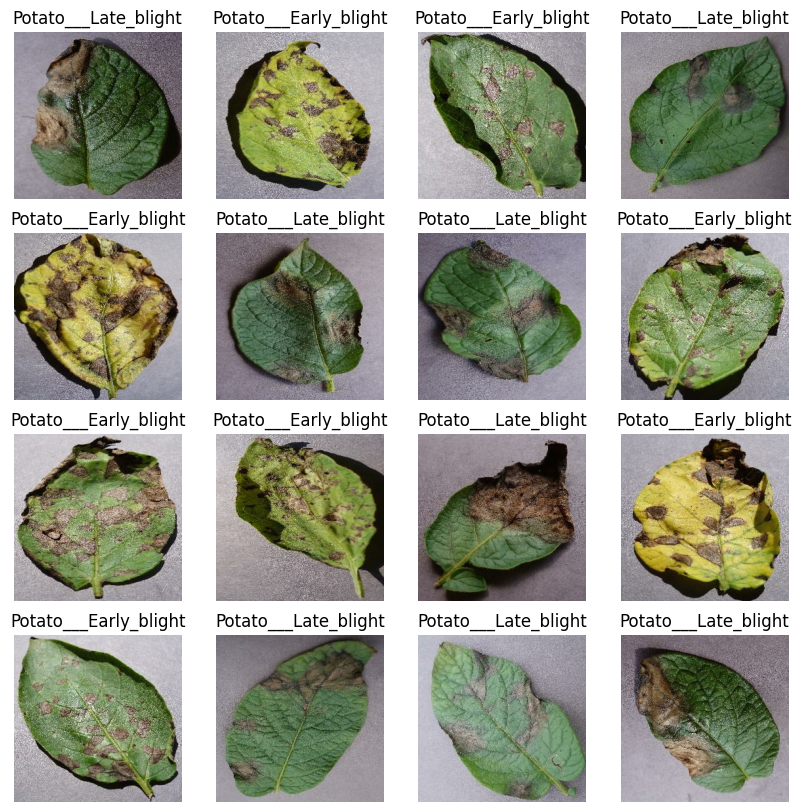

In [110]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):

    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [14]:
len(dataset)

68

In [15]:
def get_dataset_partition_tf(ds, train_split = 0.8, val_split = 0.1,
                             test_split = 0.1, shuffle = True, shuffle_size=10000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=67)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [17]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [82]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [83]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (32, 60, 60, 64)         

In [84]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [85]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
    
)

Epoch 1/50
54/54 [==============================] - 3s 56ms/step - loss: 0.9227 - accuracy: 0.4871 - val_loss: 0.9017 - val_accuracy: 0.4531
Epoch 2/50
54/54 [==============================] - 3s 50ms/step - loss: 0.8828 - accuracy: 0.4800 - val_loss: 0.8924 - val_accuracy: 0.4271
Epoch 3/50
54/54 [==============================] - 3s 50ms/step - loss: 0.8329 - accuracy: 0.6455 - val_loss: 0.7844 - val_accuracy: 0.6667
Epoch 4/50
54/54 [==============================] - 3s 50ms/step - loss: 0.6332 - accuracy: 0.7641 - val_loss: 0.4872 - val_accuracy: 0.8021
Epoch 5/50
54/54 [==============================] - 3s 50ms/step - loss: 0.4087 - accuracy: 0.8322 - val_loss: 0.3245 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 3s 51ms/step - loss: 0.2723 - accuracy: 0.8985 - val_loss: 0.2637 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 3s 52ms/step - loss: 0.2326 - accuracy: 0.9049 - val_loss: 0.2183 - val_accuracy: 0.9167
Epoch 8/50
54

In [86]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 0s 18ms/step - loss: 0.0052 - accuracy: 1.0000


In [87]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

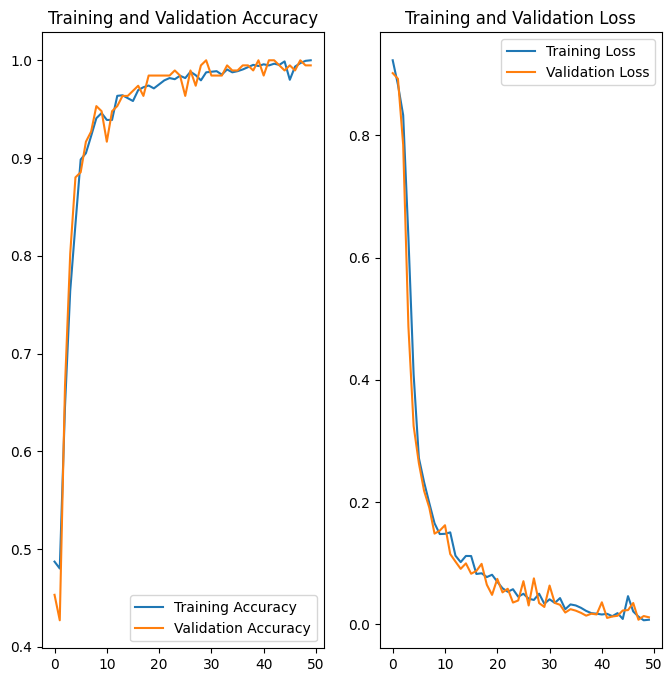

In [120]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label = 'Validation Accuracy' )
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label = 'Training Loss')
plt.plot(range(EPOCHS),val_loss, label = 'Validation Loss' )
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 16ms/step
prediction label: Potato___Early_blight


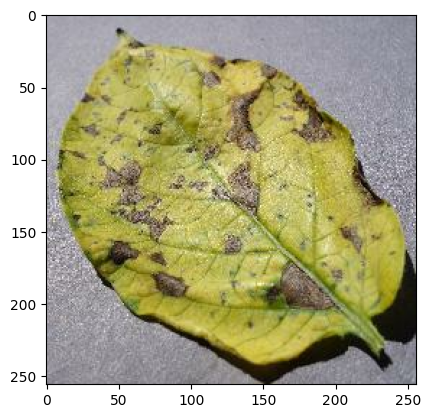

In [91]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()



    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("prediction label:", class_names[np.argmax(batch_prediction[0])])

In [92]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 8ms/step


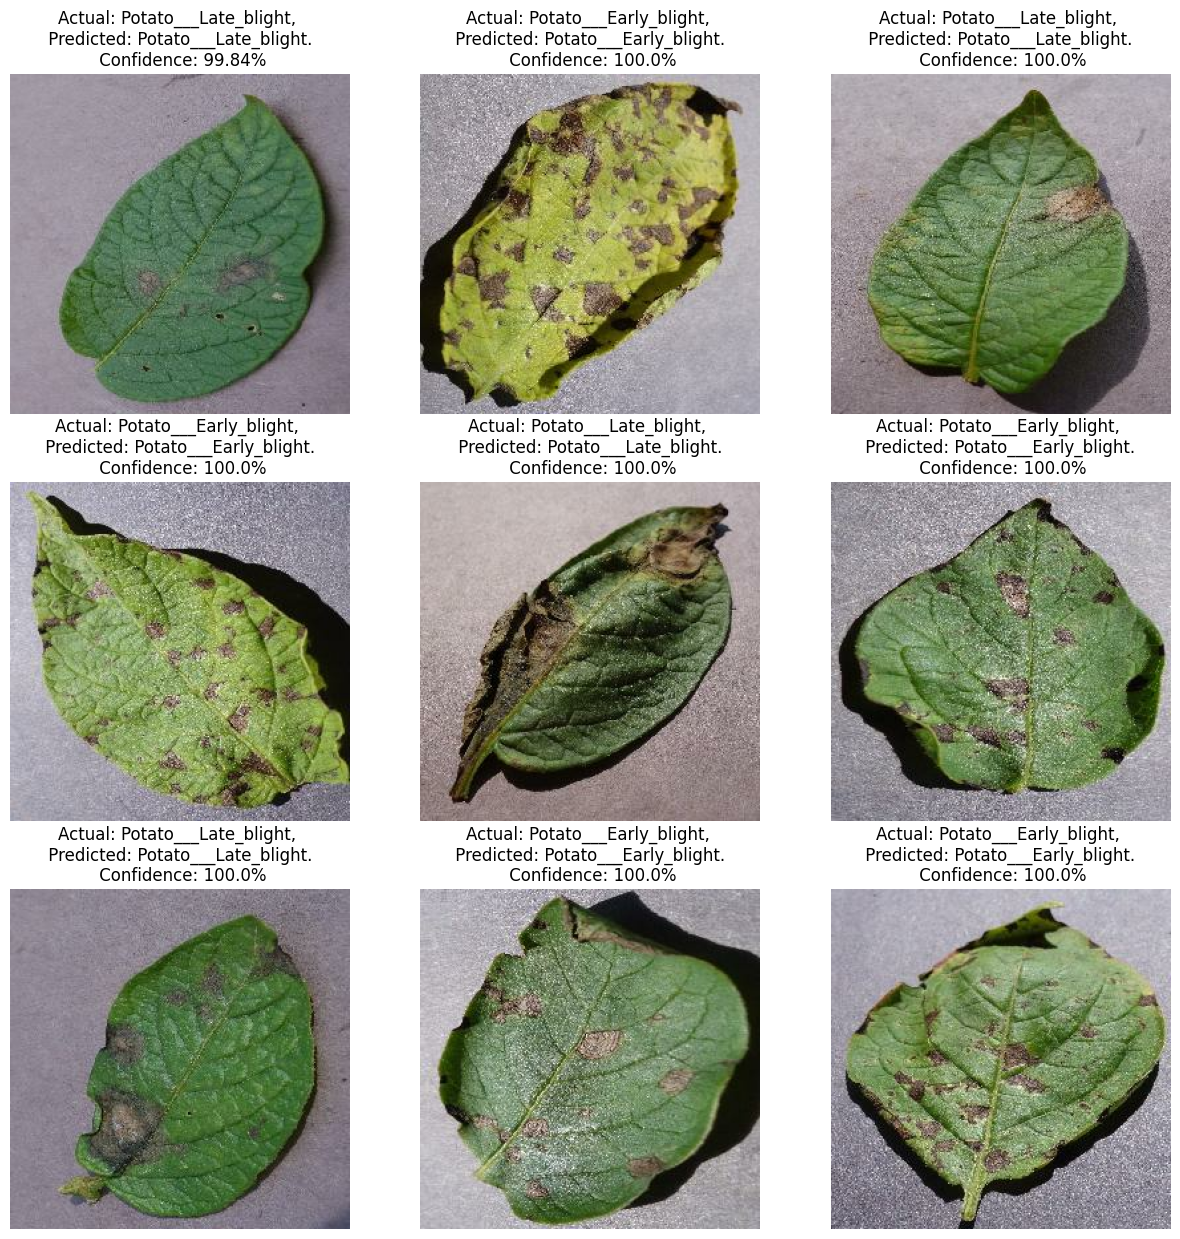

In [113]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")
        

In [114]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")